### Import headers

In [4]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
sys.path.append("..")

import argparse
import os
import time
from dataclasses import dataclass

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch import nn

from dataloader import cifar10, mnist
from models import FullyConnectedNet, LeNet
from src import hessians, lanczos, regularization

device = "cuda" if torch.cuda.is_available() else "cpu"
root = ".."

### Define a wrapper function

This makes my life more easier

In [9]:
def compute_eigvals(data, target, path:int, network: str, loss:str, alpha: float, num_eigval: int=500):
    # Network configuration
    if network == "LeNet":
        net = LeNet().to(device)
    else:
        net = FullyConnectedNet(28 * 28, 8, 10, 3, 0.1).to(device)
        flatten = True
    net_name = net.__class__.__name__

    if device == "cuda":
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    # Load checkpoint.
    assert os.path.isfile(
        f"{root}/checkpoints/Figure_2/{path}/{net_name}/{loss}/ckpt_{alpha}.pth"
    ), "Error: no checkpoint file found!: "+ f"checkpoints/Figure_2/{path}/{net_name}/{loss}/ckpt_{alpha}.pth"
    checkpoint = torch.load(f"{root}/checkpoints/Figure_2/{path}/{net_name}/{loss}/ckpt_{alpha}.pth")
    net.load_state_dict(checkpoint["net"])
    assert (
        checkpoint["alpha"] == alpha
    ), "Error: alpha is not equal to checkpoint value!"
    assert (
        checkpoint["criterion"] == loss
    ), "Error: loss is not equal to checkpoint value!"

    # Loss configuration
    if loss == "cross_entropy":
        criterion = regularization.RegularizedLoss(
            net, nn.CrossEntropyLoss(), alpha
        )
        one_hot = False
    else:
        criterion = regularization.RegularizedLoss(net, nn.MSELoss(), alpha)
        one_hot = True
        
    loss = criterion(net(data.to(device)), target.to(device))

    start = time.time()
    if device == "cuda":
        eigvals_lanczos = lanczos.lanczos(
            loss,
            net,
            num_eigenthings=num_eigval,
            tol=1e-4,
            use_gpu=True,
        )
    else:
        eigvals_lanczos = lanczos.lanczos(
            loss,
            net,
            num_eigenthings=num_eigval,
            tol=1e-4,
        )

    return np.sum(eigvals_lanczos < -1e-8)

### Call dataloaders

In [6]:
#LeNet, CIFAR10
#FCN, MNIST
#loss: cross_entropy, mse
#Models: 1-10
#alpha 0.00 - 0.25, 0.01

num_eigval = 500

# Data
batch_size = 512
num_workers = 2

data_loader_mnist = mnist.MNISTDataLoader(batch_size, num_workers, one_hot=False, flatten=True)
_, _, test_loader_mnist_ce = data_loader_mnist.get_data_loaders()

data_loader_mnist = mnist.MNISTDataLoader(batch_size, num_workers, one_hot=True, flatten=True)
_, _, test_loader_mnist_mse = data_loader_mnist.get_data_loaders()

data_loader_cifar10 = cifar10.CIFAR10DataLoader(batch_size, num_workers, one_hot=False)
_, _, test_loader_cifar10_ce = data_loader_cifar10.get_data_loaders()

data_loader_cifar10 = cifar10.CIFAR10DataLoader(batch_size, num_workers, one_hot=True)
_, _, test_loader_cifar10_mse = data_loader_cifar10.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
def recursive_computation(data_loader, network, loss):
    ratio_list = []
    for alpha in range(0, 26):
        alpha /= 100.
        num_negative = []
        for path  in range(1,101):
            data, target = next(iter(data_loader))
            result = compute_eigvals(data, target, path, network, loss, alpha, num_eigval)
            num_negative.append(result / num_eigval)
            print(f"path: {path}, num negative eigvals: {result}")
        average = sum(num_negative)/len(num_negative)*100
        print(alpha, f"{average = :.2f} %")
        ratio_list.append(average)
    return ratio_list

In [14]:
ratio_list_mnist_ce = recursive_computation(test_loader_mnist_mse, "FCN", "mse")

path: 1, num negative eigvals: 24
path: 2, num negative eigvals: 25
path: 3, num negative eigvals: 23
path: 4, num negative eigvals: 23
path: 5, num negative eigvals: 22
path: 6, num negative eigvals: 22
path: 7, num negative eigvals: 23
path: 8, num negative eigvals: 21
path: 9, num negative eigvals: 25
path: 10, num negative eigvals: 23
path: 11, num negative eigvals: 22
path: 12, num negative eigvals: 21
path: 13, num negative eigvals: 23
path: 14, num negative eigvals: 22
path: 15, num negative eigvals: 23
path: 16, num negative eigvals: 23
path: 17, num negative eigvals: 23
path: 18, num negative eigvals: 21
path: 19, num negative eigvals: 23
path: 20, num negative eigvals: 25
path: 21, num negative eigvals: 24
path: 22, num negative eigvals: 25
path: 23, num negative eigvals: 23
path: 24, num negative eigvals: 23
path: 25, num negative eigvals: 25
path: 26, num negative eigvals: 23
path: 27, num negative eigvals: 23
path: 28, num negative eigvals: 23
path: 29, num negative eigval

path: 35, num negative eigvals: 25
path: 36, num negative eigvals: 16
path: 37, num negative eigvals: 15
path: 38, num negative eigvals: 19
path: 39, num negative eigvals: 15
path: 40, num negative eigvals: 15
path: 41, num negative eigvals: 15
path: 42, num negative eigvals: 20
path: 43, num negative eigvals: 18
path: 44, num negative eigvals: 19
path: 45, num negative eigvals: 19
path: 46, num negative eigvals: 19
path: 47, num negative eigvals: 21
path: 48, num negative eigvals: 19
path: 49, num negative eigvals: 18
path: 50, num negative eigvals: 18
path: 51, num negative eigvals: 21
path: 52, num negative eigvals: 17
path: 53, num negative eigvals: 21
path: 54, num negative eigvals: 19
path: 55, num negative eigvals: 17
path: 56, num negative eigvals: 15
path: 57, num negative eigvals: 15
path: 58, num negative eigvals: 21
path: 59, num negative eigvals: 18
path: 60, num negative eigvals: 19
path: 61, num negative eigvals: 18
path: 62, num negative eigvals: 21
path: 63, num negati

path: 71, num negative eigvals: 5
path: 72, num negative eigvals: 5
path: 73, num negative eigvals: 6
path: 74, num negative eigvals: 4
path: 75, num negative eigvals: 2
path: 76, num negative eigvals: 4
path: 77, num negative eigvals: 6
path: 78, num negative eigvals: 6
path: 79, num negative eigvals: 4
path: 80, num negative eigvals: 6
path: 81, num negative eigvals: 4
path: 82, num negative eigvals: 6
path: 83, num negative eigvals: 6
path: 84, num negative eigvals: 6
path: 85, num negative eigvals: 5
path: 86, num negative eigvals: 6
path: 87, num negative eigvals: 4
path: 88, num negative eigvals: 6
path: 89, num negative eigvals: 6
path: 90, num negative eigvals: 4
path: 91, num negative eigvals: 4
path: 92, num negative eigvals: 4
path: 93, num negative eigvals: 7
path: 94, num negative eigvals: 3
path: 95, num negative eigvals: 4
path: 96, num negative eigvals: 2
path: 97, num negative eigvals: 6
path: 98, num negative eigvals: 4
path: 99, num negative eigvals: 6
path: 100, num

path: 11, num negative eigvals: 0
path: 12, num negative eigvals: 0
path: 13, num negative eigvals: 0
path: 14, num negative eigvals: 0
path: 15, num negative eigvals: 0
path: 16, num negative eigvals: 0
path: 17, num negative eigvals: 0
path: 18, num negative eigvals: 0
path: 19, num negative eigvals: 0
path: 20, num negative eigvals: 0
path: 21, num negative eigvals: 0
path: 22, num negative eigvals: 0
path: 23, num negative eigvals: 0
path: 24, num negative eigvals: 0
path: 25, num negative eigvals: 0
path: 26, num negative eigvals: 0
path: 27, num negative eigvals: 0
path: 28, num negative eigvals: 0
path: 29, num negative eigvals: 0
path: 30, num negative eigvals: 0
path: 31, num negative eigvals: 0
path: 32, num negative eigvals: 0
path: 33, num negative eigvals: 0
path: 34, num negative eigvals: 0
path: 35, num negative eigvals: 0
path: 36, num negative eigvals: 0
path: 37, num negative eigvals: 0
path: 38, num negative eigvals: 0
path: 39, num negative eigvals: 0
path: 40, num 

path: 52, num negative eigvals: 0
path: 53, num negative eigvals: 0
path: 54, num negative eigvals: 0
path: 55, num negative eigvals: 0
path: 56, num negative eigvals: 0
path: 57, num negative eigvals: 0
path: 58, num negative eigvals: 0
path: 59, num negative eigvals: 0
path: 60, num negative eigvals: 0
path: 61, num negative eigvals: 0
path: 62, num negative eigvals: 0
path: 63, num negative eigvals: 0
path: 64, num negative eigvals: 0
path: 65, num negative eigvals: 0
path: 66, num negative eigvals: 0
path: 67, num negative eigvals: 0
path: 68, num negative eigvals: 0
path: 69, num negative eigvals: 0
path: 70, num negative eigvals: 0
path: 71, num negative eigvals: 0
path: 72, num negative eigvals: 0
path: 73, num negative eigvals: 0
path: 74, num negative eigvals: 0
path: 75, num negative eigvals: 0
path: 76, num negative eigvals: 0
path: 77, num negative eigvals: 0
path: 78, num negative eigvals: 0
path: 79, num negative eigvals: 0
path: 80, num negative eigvals: 0
path: 81, num 

path: 93, num negative eigvals: 0
path: 94, num negative eigvals: 0
path: 95, num negative eigvals: 0
path: 96, num negative eigvals: 0
path: 97, num negative eigvals: 0
path: 98, num negative eigvals: 0
path: 99, num negative eigvals: 0
path: 100, num negative eigvals: 0
0.11 average = 0.00 %
path: 1, num negative eigvals: 0
path: 2, num negative eigvals: 0
path: 3, num negative eigvals: 0
path: 4, num negative eigvals: 0
path: 5, num negative eigvals: 0
path: 6, num negative eigvals: 0
path: 7, num negative eigvals: 0
path: 8, num negative eigvals: 0
path: 9, num negative eigvals: 0
path: 10, num negative eigvals: 0
path: 11, num negative eigvals: 0
path: 12, num negative eigvals: 0
path: 13, num negative eigvals: 0
path: 14, num negative eigvals: 0
path: 15, num negative eigvals: 0
path: 16, num negative eigvals: 0
path: 17, num negative eigvals: 0
path: 18, num negative eigvals: 0
path: 19, num negative eigvals: 0
path: 20, num negative eigvals: 0
path: 21, num negative eigvals: 0


path: 33, num negative eigvals: 0
path: 34, num negative eigvals: 0
path: 35, num negative eigvals: 0
path: 36, num negative eigvals: 0
path: 37, num negative eigvals: 0
path: 38, num negative eigvals: 0
path: 39, num negative eigvals: 0
path: 40, num negative eigvals: 0
path: 41, num negative eigvals: 0
path: 42, num negative eigvals: 0
path: 43, num negative eigvals: 0
path: 44, num negative eigvals: 0
path: 45, num negative eigvals: 0
path: 46, num negative eigvals: 0
path: 47, num negative eigvals: 0
path: 48, num negative eigvals: 0
path: 49, num negative eigvals: 0
path: 50, num negative eigvals: 0
path: 51, num negative eigvals: 0
path: 52, num negative eigvals: 0
path: 53, num negative eigvals: 0
path: 54, num negative eigvals: 0
path: 55, num negative eigvals: 0
path: 56, num negative eigvals: 0
path: 57, num negative eigvals: 0
path: 58, num negative eigvals: 0
path: 59, num negative eigvals: 0
path: 60, num negative eigvals: 0
path: 61, num negative eigvals: 0
path: 62, num 

path: 74, num negative eigvals: 0
path: 75, num negative eigvals: 0
path: 76, num negative eigvals: 0
path: 77, num negative eigvals: 0
path: 78, num negative eigvals: 0
path: 79, num negative eigvals: 0
path: 80, num negative eigvals: 0
path: 81, num negative eigvals: 0
path: 82, num negative eigvals: 0
path: 83, num negative eigvals: 0
path: 84, num negative eigvals: 0
path: 85, num negative eigvals: 0
path: 86, num negative eigvals: 0
path: 87, num negative eigvals: 0
path: 88, num negative eigvals: 0
path: 89, num negative eigvals: 0
path: 90, num negative eigvals: 0
path: 91, num negative eigvals: 0
path: 92, num negative eigvals: 0
path: 93, num negative eigvals: 0
path: 94, num negative eigvals: 0
path: 95, num negative eigvals: 0
path: 96, num negative eigvals: 0
path: 97, num negative eigvals: 0
path: 98, num negative eigvals: 0
path: 99, num negative eigvals: 0
path: 100, num negative eigvals: 0
0.16 average = 0.00 %
path: 1, num negative eigvals: 0
path: 2, num negative eigv

path: 14, num negative eigvals: 0
path: 15, num negative eigvals: 0
path: 16, num negative eigvals: 0
path: 17, num negative eigvals: 0
path: 18, num negative eigvals: 0
path: 19, num negative eigvals: 0
path: 20, num negative eigvals: 0
path: 21, num negative eigvals: 0
path: 22, num negative eigvals: 0
path: 23, num negative eigvals: 0
path: 24, num negative eigvals: 0
path: 25, num negative eigvals: 0
path: 26, num negative eigvals: 0
path: 27, num negative eigvals: 0
path: 28, num negative eigvals: 0
path: 29, num negative eigvals: 0
path: 30, num negative eigvals: 0
path: 31, num negative eigvals: 0
path: 32, num negative eigvals: 0
path: 33, num negative eigvals: 0
path: 34, num negative eigvals: 0
path: 35, num negative eigvals: 0
path: 36, num negative eigvals: 0
path: 37, num negative eigvals: 0
path: 38, num negative eigvals: 0
path: 39, num negative eigvals: 0
path: 40, num negative eigvals: 0
path: 41, num negative eigvals: 0
path: 42, num negative eigvals: 0
path: 43, num 

path: 55, num negative eigvals: 0
path: 56, num negative eigvals: 0
path: 57, num negative eigvals: 0
path: 58, num negative eigvals: 0
path: 59, num negative eigvals: 0
path: 60, num negative eigvals: 0
path: 61, num negative eigvals: 0
path: 62, num negative eigvals: 0
path: 63, num negative eigvals: 0
path: 64, num negative eigvals: 0
path: 65, num negative eigvals: 0
path: 66, num negative eigvals: 0
path: 67, num negative eigvals: 0
path: 68, num negative eigvals: 0
path: 69, num negative eigvals: 0
path: 70, num negative eigvals: 0
path: 71, num negative eigvals: 0
path: 72, num negative eigvals: 0
path: 73, num negative eigvals: 0
path: 74, num negative eigvals: 0
path: 75, num negative eigvals: 0
path: 76, num negative eigvals: 0
path: 77, num negative eigvals: 0
path: 78, num negative eigvals: 0
path: 79, num negative eigvals: 0
path: 80, num negative eigvals: 0
path: 81, num negative eigvals: 0
path: 82, num negative eigvals: 0
path: 83, num negative eigvals: 0
path: 84, num 

path: 96, num negative eigvals: 0
path: 97, num negative eigvals: 0
path: 98, num negative eigvals: 0
path: 99, num negative eigvals: 0
path: 100, num negative eigvals: 0
0.23 average = 0.00 %
path: 1, num negative eigvals: 0
path: 2, num negative eigvals: 0
path: 3, num negative eigvals: 0
path: 4, num negative eigvals: 0
path: 5, num negative eigvals: 0
path: 6, num negative eigvals: 0
path: 7, num negative eigvals: 0
path: 8, num negative eigvals: 0
path: 9, num negative eigvals: 0
path: 10, num negative eigvals: 0
path: 11, num negative eigvals: 0
path: 12, num negative eigvals: 0
path: 13, num negative eigvals: 0
path: 14, num negative eigvals: 0
path: 15, num negative eigvals: 0
path: 16, num negative eigvals: 0
path: 17, num negative eigvals: 0
path: 18, num negative eigvals: 0
path: 19, num negative eigvals: 0
path: 20, num negative eigvals: 0
path: 21, num negative eigvals: 0
path: 22, num negative eigvals: 0
path: 23, num negative eigvals: 0
path: 24, num negative eigvals: 0


In [17]:
ratio_list_mnist_mse = recursive_computation(test_loader_mnist_ce, "FCN", "cross_entropy")

path: 1, num negative eigvals: 90
path: 2, num negative eigvals: 89
path: 3, num negative eigvals: 91
path: 4, num negative eigvals: 93
path: 5, num negative eigvals: 93
path: 6, num negative eigvals: 93
path: 7, num negative eigvals: 92
path: 8, num negative eigvals: 95
path: 9, num negative eigvals: 94
path: 10, num negative eigvals: 94
path: 11, num negative eigvals: 90
path: 12, num negative eigvals: 91
path: 13, num negative eigvals: 91
path: 14, num negative eigvals: 92
path: 15, num negative eigvals: 91
path: 16, num negative eigvals: 91
path: 17, num negative eigvals: 93
path: 18, num negative eigvals: 91
path: 19, num negative eigvals: 93
path: 20, num negative eigvals: 92
path: 21, num negative eigvals: 93
path: 22, num negative eigvals: 91
path: 23, num negative eigvals: 92
path: 24, num negative eigvals: 94
path: 25, num negative eigvals: 92
path: 26, num negative eigvals: 88
path: 27, num negative eigvals: 91
path: 28, num negative eigvals: 91
path: 29, num negative eigval

path: 35, num negative eigvals: 90
path: 36, num negative eigvals: 86
path: 37, num negative eigvals: 89
path: 38, num negative eigvals: 88
path: 39, num negative eigvals: 88
path: 40, num negative eigvals: 87
path: 41, num negative eigvals: 88
path: 42, num negative eigvals: 85
path: 43, num negative eigvals: 88
path: 44, num negative eigvals: 85
path: 45, num negative eigvals: 88
path: 46, num negative eigvals: 87
path: 47, num negative eigvals: 84
path: 48, num negative eigvals: 86
path: 49, num negative eigvals: 90
path: 50, num negative eigvals: 89
path: 51, num negative eigvals: 86
path: 52, num negative eigvals: 87
path: 53, num negative eigvals: 87
path: 54, num negative eigvals: 88
path: 55, num negative eigvals: 90
path: 56, num negative eigvals: 88
path: 57, num negative eigvals: 87
path: 58, num negative eigvals: 87
path: 59, num negative eigvals: 84
path: 60, num negative eigvals: 89
path: 61, num negative eigvals: 85
path: 62, num negative eigvals: 91
path: 63, num negati

path: 69, num negative eigvals: 86
path: 70, num negative eigvals: 82
path: 71, num negative eigvals: 83
path: 72, num negative eigvals: 84
path: 73, num negative eigvals: 82
path: 74, num negative eigvals: 82
path: 75, num negative eigvals: 83
path: 76, num negative eigvals: 87
path: 77, num negative eigvals: 88
path: 78, num negative eigvals: 79
path: 79, num negative eigvals: 83
path: 80, num negative eigvals: 87
path: 81, num negative eigvals: 84
path: 82, num negative eigvals: 84
path: 83, num negative eigvals: 85
path: 84, num negative eigvals: 82
path: 85, num negative eigvals: 82
path: 86, num negative eigvals: 86
path: 87, num negative eigvals: 82
path: 88, num negative eigvals: 84
path: 89, num negative eigvals: 80
path: 90, num negative eigvals: 81
path: 91, num negative eigvals: 83
path: 92, num negative eigvals: 84
path: 93, num negative eigvals: 86
path: 94, num negative eigvals: 80
path: 95, num negative eigvals: 84
path: 96, num negative eigvals: 83
path: 97, num negati

path: 2, num negative eigvals: 76
path: 3, num negative eigvals: 78
path: 4, num negative eigvals: 76
path: 5, num negative eigvals: 80
path: 6, num negative eigvals: 78
path: 7, num negative eigvals: 77
path: 8, num negative eigvals: 80
path: 9, num negative eigvals: 77
path: 10, num negative eigvals: 78
path: 11, num negative eigvals: 78
path: 12, num negative eigvals: 76
path: 13, num negative eigvals: 78
path: 14, num negative eigvals: 81
path: 15, num negative eigvals: 78
path: 16, num negative eigvals: 79
path: 17, num negative eigvals: 77
path: 18, num negative eigvals: 79
path: 19, num negative eigvals: 81
path: 20, num negative eigvals: 77
path: 21, num negative eigvals: 80
path: 22, num negative eigvals: 82
path: 23, num negative eigvals: 78
path: 24, num negative eigvals: 78
path: 25, num negative eigvals: 77
path: 26, num negative eigvals: 76
path: 27, num negative eigvals: 78
path: 28, num negative eigvals: 76
path: 29, num negative eigvals: 76
path: 30, num negative eigva

path: 36, num negative eigvals: 73
path: 37, num negative eigvals: 75
path: 38, num negative eigvals: 79
path: 39, num negative eigvals: 75
path: 40, num negative eigvals: 77
path: 41, num negative eigvals: 74
path: 42, num negative eigvals: 75
path: 43, num negative eigvals: 76
path: 44, num negative eigvals: 73
path: 45, num negative eigvals: 72
path: 46, num negative eigvals: 74
path: 47, num negative eigvals: 73
path: 48, num negative eigvals: 72
path: 49, num negative eigvals: 74
path: 50, num negative eigvals: 77
path: 51, num negative eigvals: 72
path: 52, num negative eigvals: 76
path: 53, num negative eigvals: 71
path: 54, num negative eigvals: 75
path: 55, num negative eigvals: 75
path: 56, num negative eigvals: 77
path: 57, num negative eigvals: 79
path: 58, num negative eigvals: 75
path: 59, num negative eigvals: 72
path: 60, num negative eigvals: 75
path: 61, num negative eigvals: 75
path: 62, num negative eigvals: 76
path: 63, num negative eigvals: 74
path: 64, num negati

path: 70, num negative eigvals: 71
path: 71, num negative eigvals: 70
path: 72, num negative eigvals: 72
path: 73, num negative eigvals: 69
path: 74, num negative eigvals: 74
path: 75, num negative eigvals: 73
path: 76, num negative eigvals: 72
path: 77, num negative eigvals: 73
path: 78, num negative eigvals: 69
path: 79, num negative eigvals: 74
path: 80, num negative eigvals: 73
path: 81, num negative eigvals: 73
path: 82, num negative eigvals: 71
path: 83, num negative eigvals: 73
path: 84, num negative eigvals: 72
path: 85, num negative eigvals: 71
path: 86, num negative eigvals: 74
path: 87, num negative eigvals: 70
path: 88, num negative eigvals: 73
path: 89, num negative eigvals: 69
path: 90, num negative eigvals: 77
path: 91, num negative eigvals: 71
path: 92, num negative eigvals: 68
path: 93, num negative eigvals: 72
path: 94, num negative eigvals: 69
path: 95, num negative eigvals: 71
path: 96, num negative eigvals: 71
path: 97, num negative eigvals: 74
path: 98, num negati

path: 3, num negative eigvals: 65
path: 4, num negative eigvals: 65
path: 5, num negative eigvals: 67
path: 6, num negative eigvals: 70
path: 7, num negative eigvals: 67
path: 8, num negative eigvals: 69
path: 9, num negative eigvals: 64
path: 10, num negative eigvals: 69
path: 11, num negative eigvals: 64
path: 12, num negative eigvals: 70
path: 13, num negative eigvals: 67
path: 14, num negative eigvals: 69
path: 15, num negative eigvals: 71
path: 16, num negative eigvals: 68
path: 17, num negative eigvals: 66
path: 18, num negative eigvals: 68
path: 19, num negative eigvals: 70
path: 20, num negative eigvals: 69
path: 21, num negative eigvals: 69
path: 22, num negative eigvals: 67
path: 23, num negative eigvals: 67
path: 24, num negative eigvals: 65
path: 25, num negative eigvals: 69
path: 26, num negative eigvals: 65
path: 27, num negative eigvals: 67
path: 28, num negative eigvals: 67
path: 29, num negative eigvals: 71
path: 30, num negative eigvals: 68
path: 31, num negative eigv

path: 37, num negative eigvals: 64
path: 38, num negative eigvals: 64
path: 39, num negative eigvals: 65
path: 40, num negative eigvals: 64
path: 41, num negative eigvals: 64
path: 42, num negative eigvals: 66
path: 43, num negative eigvals: 67
path: 44, num negative eigvals: 64
path: 45, num negative eigvals: 63
path: 46, num negative eigvals: 66
path: 47, num negative eigvals: 65
path: 48, num negative eigvals: 65
path: 49, num negative eigvals: 63
path: 50, num negative eigvals: 64
path: 51, num negative eigvals: 66
path: 52, num negative eigvals: 63
path: 53, num negative eigvals: 61
path: 54, num negative eigvals: 60
path: 55, num negative eigvals: 65
path: 56, num negative eigvals: 67
path: 57, num negative eigvals: 65
path: 58, num negative eigvals: 61
path: 59, num negative eigvals: 61
path: 60, num negative eigvals: 68
path: 61, num negative eigvals: 67
path: 62, num negative eigvals: 69
path: 63, num negative eigvals: 60
path: 64, num negative eigvals: 66
path: 65, num negati

path: 71, num negative eigvals: 60
path: 72, num negative eigvals: 59
path: 73, num negative eigvals: 58
path: 74, num negative eigvals: 61
path: 75, num negative eigvals: 62
path: 76, num negative eigvals: 60
path: 77, num negative eigvals: 61
path: 78, num negative eigvals: 65
path: 79, num negative eigvals: 65
path: 80, num negative eigvals: 65
path: 81, num negative eigvals: 61
path: 82, num negative eigvals: 64
path: 83, num negative eigvals: 64
path: 84, num negative eigvals: 64
path: 85, num negative eigvals: 60
path: 86, num negative eigvals: 66
path: 87, num negative eigvals: 61
path: 88, num negative eigvals: 65
path: 89, num negative eigvals: 64
path: 90, num negative eigvals: 66
path: 91, num negative eigvals: 63
path: 92, num negative eigvals: 64
path: 93, num negative eigvals: 68
path: 94, num negative eigvals: 62
path: 95, num negative eigvals: 63
path: 96, num negative eigvals: 63
path: 97, num negative eigvals: 61
path: 98, num negative eigvals: 66
path: 99, num negati

path: 4, num negative eigvals: 59
path: 5, num negative eigvals: 60
path: 6, num negative eigvals: 61
path: 7, num negative eigvals: 59
path: 8, num negative eigvals: 61
path: 9, num negative eigvals: 52
path: 10, num negative eigvals: 58
path: 11, num negative eigvals: 53
path: 12, num negative eigvals: 59
path: 13, num negative eigvals: 56
path: 14, num negative eigvals: 61
path: 15, num negative eigvals: 59
path: 16, num negative eigvals: 60
path: 17, num negative eigvals: 58
path: 18, num negative eigvals: 59
path: 19, num negative eigvals: 60
path: 20, num negative eigvals: 61
path: 21, num negative eigvals: 57
path: 22, num negative eigvals: 54
path: 23, num negative eigvals: 63
path: 24, num negative eigvals: 58
path: 25, num negative eigvals: 62
path: 26, num negative eigvals: 58
path: 27, num negative eigvals: 59
path: 28, num negative eigvals: 57
path: 29, num negative eigvals: 62
path: 30, num negative eigvals: 57
path: 31, num negative eigvals: 58
path: 32, num negative eig

path: 38, num negative eigvals: 57
path: 39, num negative eigvals: 59
path: 40, num negative eigvals: 55
path: 41, num negative eigvals: 58
path: 42, num negative eigvals: 55
path: 43, num negative eigvals: 58
path: 44, num negative eigvals: 56
path: 45, num negative eigvals: 54
path: 46, num negative eigvals: 56
path: 47, num negative eigvals: 57
path: 48, num negative eigvals: 60
path: 49, num negative eigvals: 56
path: 50, num negative eigvals: 57
path: 51, num negative eigvals: 57
path: 52, num negative eigvals: 58
path: 53, num negative eigvals: 58
path: 54, num negative eigvals: 54
path: 55, num negative eigvals: 57
path: 56, num negative eigvals: 60
path: 57, num negative eigvals: 56
path: 58, num negative eigvals: 54
path: 59, num negative eigvals: 52
path: 60, num negative eigvals: 61
path: 61, num negative eigvals: 54
path: 62, num negative eigvals: 55
path: 63, num negative eigvals: 55
path: 64, num negative eigvals: 51
path: 65, num negative eigvals: 58
path: 66, num negati

path: 72, num negative eigvals: 53
path: 73, num negative eigvals: 51
path: 74, num negative eigvals: 55
path: 75, num negative eigvals: 58
path: 76, num negative eigvals: 58
path: 77, num negative eigvals: 54
path: 78, num negative eigvals: 59
path: 79, num negative eigvals: 56
path: 80, num negative eigvals: 58
path: 81, num negative eigvals: 55
path: 82, num negative eigvals: 55
path: 83, num negative eigvals: 57
path: 84, num negative eigvals: 54
path: 85, num negative eigvals: 55
path: 86, num negative eigvals: 58
path: 87, num negative eigvals: 56
path: 88, num negative eigvals: 56
path: 89, num negative eigvals: 56
path: 90, num negative eigvals: 54
path: 91, num negative eigvals: 56
path: 92, num negative eigvals: 57
path: 93, num negative eigvals: 51
path: 94, num negative eigvals: 51
path: 95, num negative eigvals: 54
path: 96, num negative eigvals: 58
path: 97, num negative eigvals: 52
path: 98, num negative eigvals: 52
path: 99, num negative eigvals: 52
path: 100, num negat

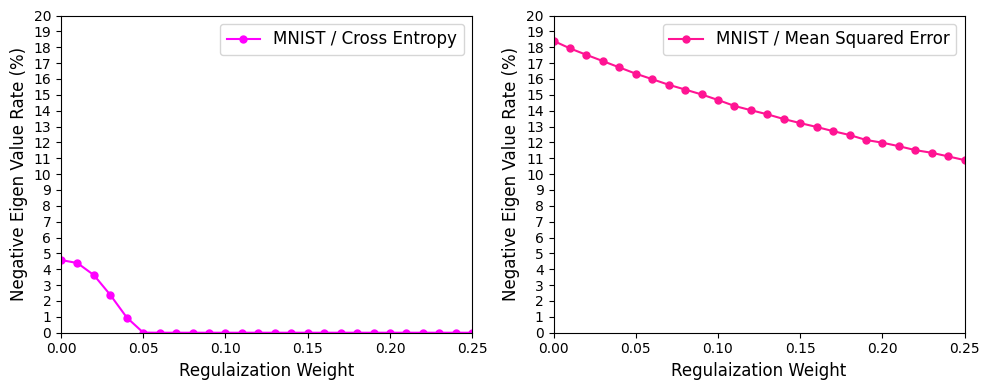

In [55]:
import matplotlib.pyplot as plt

W_reg = np.arange(0, 0.26, 0.01).tolist()

Fig = plt.figure(figsize=(10, 4))
fig1 = Fig.add_subplot(1, 2, 1)
fig2 = Fig.add_subplot(1, 2, 2)

fig1.margins(x=0, y=0)
plt.sca(fig1)
plt.plot(W_reg, ratio_list_mnist_ce, '.-', markersize="10", color="#FF00FF", label="MNIST / Cross Entropy")
plt.xlabel('Regulaization Weight', fontsize="12")
plt.ylabel('Negative Eigen Value Rate (%)', fontsize="12")
plt.xticks(np.arange(0, 0.26, 0.05))
plt.yticks(np.arange(0, 21, 1))
plt.legend(fontsize="12")

fig2.margins(x=0, y=0)
plt.sca(fig2)
plt.plot(W_reg, ratio_list_mnist_mse, '.-',  markersize="10", color="#FF1493", label="MNIST / Mean Squared Error")
plt.xlabel('Regulaization Weight', fontsize="12")
plt.ylabel('Negative Eigen Value Rate (%)', fontsize="12")
plt.xticks(np.arange(0, 0.26, 0.05))
plt.yticks(np.arange(0, 21, 1))
plt.legend(fontsize="12")

Fig.tight_layout()
Fig.savefig("Figure2.pdf", dpi=600)
Fig.show()

In [16]:
import pickle

with open('ratio_list_mnist_ce.pickle', 'wb') as f:
    pickle.dump(ratio_list_mnist_ce, f, pickle.HIGHEST_PROTOCOL)

In [18]:
with open('ratio_list_mnist_mse.pickle', 'wb') as f:
    pickle.dump(ratio_list_mnist_mse, f, pickle.HIGHEST_PROTOCOL)